# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

#### Notebook destinado a análise de Classificação dos Stacked Autoencoder (SAE)

In [1]:
import os
import sys
import time
from datetime import datetime, timedelta
sys.path.insert(0,'..')

from noveltyDetectionConfig import CONFIG
import numpy as np
import itertools
import multiprocessing
import pprint 

from SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

from Functions.telegrambot import Bot

my_bot = Bot("lisa_thebot")

pp = pprint.PrettyPrinter(indent=1)

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


training_params = {
    "Technique": "StackedAutoEncoder"
}
# cadc84ee1837f4aa2919c45f8cdf287fcb18166212d57eb4d47e47c6a0bb0450 tanh
# 99092520b628f4d5de192d532f45e3cc9423cd88cd1f6b94423f81ba4fa13084
analysis = SAENoveltyDetectionAnalysis(parameters=training_params, model_hash="6fb50ab4448b5f8545344a05e5977b75d7ce23eb7e63b6111099dac6f6c1bd19", #model_hash="ac4069e4f7fd06ed0e516577c5a9fa01f26ffdffbea1b8908bef4b1a5b60b927",
                                       load_hash=True, load_data=True, verbose=False)
all_data, all_trgt, trgt_sparse = analysis.getData()

SAE = analysis.createSAEModels()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

Using TensorFlow backend.


Reading from /home/vinicius.mello/Workspace/SonarAnalysis_2/Results/NoveltyDetection/StackedAutoEncoder/outputs/6fb50ab4448b5f8545344a05e5977b75d7ce23eb7e63b6111099dac6f6c1bd19/parameters.json
[+] Time to read data file: 1.06464099884 seconds
Balacing data...
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [ ]:
print analysis.getBaseResultsPath()
pp.pprint(analysis.parameters)

### SP Index analysis for a neuron variation at autoencoder

In [ ]:
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [400]

step = 100
neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

analysis_name = 'sp_index_%i_layer'%(layer)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

if os.path.exists(analysis_file):
    os.remove(analysis_file)
    
verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)


results = {}
spIndex = np.zeros([len(analysis.class_labels), analysis.parameters["HyperParameters"]["n_folds"], len(neurons_mat)])

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        folds = range(len(analysis.CVO[inovelty]))
        for ifold in folds:    
            train_id, test_id = analysis.CVO[inovelty][ifold]
            class_eff_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"],len(np.unique(all_trgt))])
            known_sp_mat = np.zeros([analysis.parameters["HyperParameters"]["n_folds"]])

            buff = np.zeros([len(np.unique(all_trgt))-1])
            class_eff = np.zeros([len(np.unique(all_trgt))], dtype=object)
            known_sp = np.zeros([len(np.unique(all_trgt))], dtype=object)

            def getSP(ineuron):

                scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)
                known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
                known_trgt = analysis.trn_trgt[inovelty][test_id]
                
                classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                           trgt  = analysis.trn_trgt[inovelty], 
                                                           hidden_neurons = hidden_neurons[:layer-1]+[ineuron],
                                                           layer = layer,
                                                           ifold = ifold)

                output = classifier.predict(known_data)
                
                num_known_classes = trn_trgt_sparse[inovelty].shape[1]
                thr_value = 0.3
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff

                sp_index = (np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))

                
                return ineuron, sp_index

            # Start Parallel processing
            p = multiprocessing.Pool(processes=num_processes)

            if verbose:
                print '[*] Calculating SP Index ...'
            try:
                results = p.map(getSP, neurons_mat)
                p.close()
                p.join()
                for ineuron_index in range(len(neurons_mat)):
                    spIndex[inovelty, ifold, neurons_mat.index(results[ineuron_index][0])] = results[ineuron_index][1]
            except Exception as e: 
                p.close()
                p.join()          
                print("Erro: {}".format(str(e)))
                break
    joblib.dump([neurons_mat,spIndex],analysis_file,compress=9)
else:
    [neurons_mat, spIndex] = joblib.load(analysis_file)

    
for inovelty in range(len(analysis.class_labels)):
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)
    
    mean_sp = np.mean(spIndex[inovelty,:], axis=0)
    error_sp = np.std(spIndex[inovelty,:,:], axis=0)
    
    ax.plot(neurons_mat, mean_sp, color='b', alpha=0.7, linewidth=2.5, label='SP Index Test Data')
    
    ax.fill_between(neurons_mat, mean_sp+error_sp, mean_sp-error_sp, facecolor='blue', alpha=0.3)
    
    ax.set_title('SP Index x Neurons (Class {} as novelty)'.format(analysis.class_labels[inovelty]),
                                  fontsize=14, fontweight='bold')
    ax.set_ylabel('SP Index', fontsize=22)
    ax.set_xlabel('Neurons', fontsize=22)
    ax.grid()
    ax.legend()
    plt.tight_layout()

    #Save the figure
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons[:layer-1])
    file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
    plt.savefig(file_name, format="png")
    my_bot.sendMessage(imgPath=file_name)
    plt.show()

### Figures of Merit for a threshold sweep at output layer

In [ ]:
# Thresolds variation x Figures of Merit
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 


inovelty = 0

# Choose neurons topology
# hidden_neurons_total = [400]
# for layer in range(1,len(hidden_neurons_total)+1):
#     hidden_neurons = hidden_neurons_total[:layer]

layer = 2
hidden_neurons = [400,300]
neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons[:layer])
analysis_name = "figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

# if os.path.exists(analysis_file):
#     os.remove(analysis_file)

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (20,15)

if not os.path.exists(analysis_file):
    # Set the threshold to be analyzed
    thr_mat = np.round(np.arange(0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    n_folds = analysis.n_folds

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])

    for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
        for ifold in range(len(analysis.CVO[inovelty])):
            train_id, test_id = analysis.CVO[inovelty][ifold]

            print 'Novelty class: %01.0f - Topology: %s - fold %i'%(novelty_class,
                                                                    SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                    ifold)
            classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                       trgt  = analysis.trn_trgt[inovelty], 
                                                       hidden_neurons = hidden_neurons[:layer],
                                                       layer = layer,
                                                       ifold = ifold)


            scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_trgt = analysis.trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))
                
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=figsize)


sp_auc = np.zeros(len(analysis.getClassLabels()))
acc_auc = np.zeros(len(analysis.getClassLabels()))
trigger_auc = np.zeros(len(analysis.getClassLabels()))
novelty_detection_auc = np.zeros(len(analysis.getClassLabels()))

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novel Det.')
            ax.errorbar(thr_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
            ax.errorbar(thr_mat,np.mean(known_trig_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_trig_mat[:,int(novelty_class),:],axis=0),fmt='o-.',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Trig.')
        else:
            ax.errorbar(thr_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='Class %s Eff.'%(analysis.getClassLabels()[iclass]))
    # AUC
    sp_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_sp_mat[:,int(inovelty),:],axis=0))
    acc_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_acc_mat[:,int(inovelty),:],axis=0))
    trigger_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_trig_mat[:,int(inovelty),:],axis=0))
    novelty_detection_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(novelty_eff_mat[:,int(inovelty),:],axis=0))
    
    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title("Class {} as novelty - Layer {} - Topology {} ".format(analysis.class_labels[inovelty], layer, neurons_str),
                 fontsize=14, fontweight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])

    ax.set_ylim([0.0, 1.3])
    y_ticks = np.arange(0.0,1.3,0.1)
    ax.set_yticks(y_ticks)
    y_tick_labels = 100*y_ticks[y_ticks<=1.0]
    y_tick_labels = y_tick_labels.astype(int)
    ax.set_yticklabels(y_tick_labels,fontsize=18)

    ax.grid()

    if inovelty > 1:
        ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Figures-of-Merit (%)',fontsize=18,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3, loc='upper center')

    plt.tight_layout()

#Save the figure
neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
plt.savefig(file_name, format="png")
try: 
    my_bot.sendMessage(imgPath=file_name)
except Exception as e:
    print("Error when sending the image to the bot. Error: {}".format(str(e)))

In [ ]:
filePath = analysis.get_pictures_zip()
my_bot.sendMessage(filePath=filePath)

### AUC Analysis

In [ ]:
# Thresolds variation x Figures of Merit
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 


inovelty = 0

# Choose neurons topology
# hidden_neurons_total = [400]
# for layer in range(1,len(hidden_neurons_total)+1):
#     hidden_neurons = hidden_neurons_total[:layer]

layer = 1
hidden_neurons = [400]
neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons[:layer])
analysis_name = "figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

# if os.path.exists(analysis_file):
#     os.remove(analysis_file)

verbose = True
figsize = (10,5)

if not os.path.exists(analysis_file):
    # Set the threshold to be analyzed
    thr_mat = np.round(np.arange(0.0,1.05,0.05),3)
    thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

    n_folds = analysis.n_folds

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
    known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])

    for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
        for ifold in range(len(analysis.CVO[inovelty])):
            print 'Novelty class: %01.0f - Topology: %s - fold %i'%(novelty_class,
                                                                    SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                    ifold)
            classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                       trgt  = analysis.trn_trgt[inovelty], 
                                                       hidden_neurons = hidden_neurons[:layer],
                                                       layer = layer,
                                                       ifold = ifold)

            scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)
            
            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_trgt = analysis.trn_trgt[inovelty][test_id]

            novelty_data = scaler.transform(all_data[all_trgt==inovelty])

            output = classifier.predict(known_data)
            novelty_output = classifier.predict(novelty_data)

            for ithr,thr_value in enumerate(thr_mat): 
                buff = np.zeros([len(np.unique(all_trgt))-1])
                for iclass, class_id in enumerate(np.unique(all_trgt)):
                    if iclass == inovelty:
                        continue
                    output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                    correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                    output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                    class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                    buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                              *np.power(np.prod(buff),1./float(len(buff)))))
                known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))
                
    joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                analysis_file,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

sp_auc = np.zeros(len(analysis.getClassLabels()))
acc_auc = np.zeros(len(analysis.getClassLabels()))
trigger_auc = np.zeros(len(analysis.getClassLabels()))
novelty_detection_auc = np.zeros(len(analysis.getClassLabels()))

fig, ax = plt.subplots(figsize=figsize)

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    # AUC
    sp_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_sp_mat[:,int(inovelty),:],axis=0))
    acc_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_acc_mat[:,int(inovelty),:],axis=0))
    trigger_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(known_trig_mat[:,int(inovelty),:],axis=0))
    novelty_detection_auc[inovelty] = analysis.relative_auc(np.array(thr_mat),np.mean(novelty_eff_mat[:,int(inovelty),:],axis=0))
    
    y_pos = np.arange(len(analysis.getClassLabels()))
    
    width = 0.2  # the width of the bars
    ax.grid(zorder=0)
    ax.barh(y_pos - width/2, novelty_detection_auc, width, align='center', label = 'Novelty Detection', zorder=3,
            color='green', ecolor='black')
    ax.barh(y_pos + width/2, sp_auc, width, align='center', label = 'SP', zorder=3,
            color='blue', ecolor='black')
    ax.barh(y_pos + 1.5*width, trigger_auc, width, align='center', label = 'Trigger', zorder=3,
            color='orange', ecolor='black')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(["Class {}".format(ilabel) for ilabel in analysis.getClassLabels()])
    ax.set_ylim((-1,3.5))
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlim((0,1))
    ax.set_xlabel('Relative AUC',
                 fontsize=14, fontweight='bold')
    ax.set_title("AUC - Layer {} - Topology {} ".format(layer, neurons_str),
                 fontsize=14, fontweight='bold')
    
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend((handles[0],handles[4],handles[8]), (labels[0],labels[4],labels[8]), loc='upper center', ncol=3)

#Save the figure
analysis_name = "auc_{}_layer_{}_neurons".format(layer,neurons_str)
neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
plt.savefig(file_name, format="png")
try: 
    my_bot.sendMessage(imgPath=file_name)
except Exception as e:
    print("Error when sending the image to the bot. Error: {}".format(str(e)))

file exists
file exists
file exists
Novelty class: 0 - Topology: 400x350x300x250x200x3 - fold 0
[-] Error: File or Directory not found. Path: /home/vinicius.mello/Workspace/SonarAnalysis_2/Results/NoveltyDetection/StackedAutoEncoder/outputs/6fb50ab4448b5f8545344a05e5977b75d7ce23eb7e63b6111099dac6f6c1bd19/classifier_model_0_novelty_400x350x300x250x200_neurons_fold_0_model.h5
Classifier - Layer: 4 - Topology: 400x350x300x250x200 - Fold: 1 of 4 Folds -  Init: 1 of 1 Inits
Autoencoder - Layer: 4 - Topology: 400x350x300x250x200 - Fold 1 of 4 Folds -  Init 1 of 1 Inits


KeyboardInterrupt: 

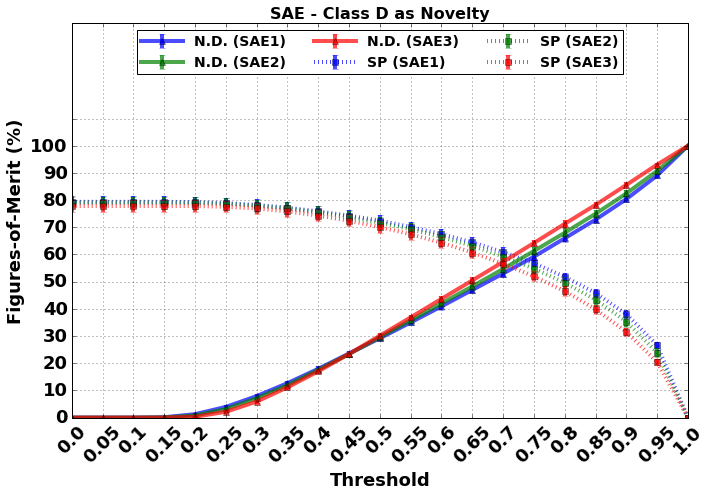

In [4]:
# Thresolds variation x Figures of Merit
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF
from Functions import FunctionsDataVisualization
import matplotlib.pyplot as plt

# Choose layer 
# layer = 2

inovelty = 3

# Choose neurons topology
hidden_neurons_total = [350,300,250,200,150,100,50]

layers = [1,2,3,4,5,6,7]

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
m_markers = ['^', 's', 'o', 'p']

figsize = (10,7)


fig = plt.subplots(figsize=figsize)

ax = plt.subplot(1,1,1)

i = 0
for layer in layers:
    hidden_neurons = hidden_neurons_total[:layer]
    neurons_str = SAE[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
    analysis_name = "figures_of_merit_{}_layer_{}_neurons".format(layer,neurons_str)
    analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

    verbose = True

    if not os.path.exists(analysis_file):
        # Set the threshold to be analyzed
        thr_mat = np.round(np.arange(0.0,1.05,0.05),3)
        thr_mat[thr_mat>-0.1] = abs(thr_mat[thr_mat>-0.1])

        n_folds = analysis.n_folds

        class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(thr_mat)])
        novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])
        known_trig_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(thr_mat)])

        for inovelty, novelty_class in enumerate(np.unique(analysis.all_trgt)):
            for ifold in range(len(analysis.CVO[inovelty])):
                train_id, test_id = analysis.CVO[inovelty][ifold]

                print 'Novelty class: %01.0f - Topology: %s - fold %i'%(novelty_class,
                                                                        SAE[inovelty].get_neurons_str(data=trn_data[inovelty], hidden_neurons=hidden_neurons)+'x'+str(trn_trgt_sparse[inovelty].shape[1]),
                                                                        ifold)
                classifier = SAE[inovelty].load_classifier(data  = analysis.trn_data[inovelty],
                                                           trgt  = analysis.trn_trgt[inovelty], 
                                                           hidden_neurons = hidden_neurons[:layer],
                                                           layer = layer,
                                                           ifold = ifold)

                
                scaler = analysis.get_data_scaler(inovelty=inovelty, ifold=ifold)

                known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
                known_trgt = analysis.trn_trgt[inovelty][test_id]

                novelty_data = scaler.transform(all_data[all_trgt==inovelty])

                output = classifier.predict(known_data)
                novelty_output = classifier.predict(novelty_data)

                for ithr,thr_value in enumerate(thr_mat): 
                    buff = np.zeros([len(np.unique(all_trgt))-1])
                    for iclass, class_id in enumerate(np.unique(all_trgt)):
                        if iclass == inovelty:
                            continue
                        output_of_class_events = output[known_trgt==iclass-(iclass>inovelty),:]
                        correct_class_output = np.argmax(output_of_class_events,axis=1)==iclass-(iclass>inovelty)
                        output_above_thr = output_of_class_events[correct_class_output,iclass-(iclass>inovelty)]>thr_value
                        class_eff_mat[ifold, inovelty, iclass, ithr] = float(sum(output_above_thr))/float(len(output_of_class_events))
                        buff[iclass-(iclass>inovelty)] = class_eff_mat[ifold, inovelty, iclass, ithr]
                    novelty_eff_mat[ifold, inovelty, ithr] = float(sum(1-(novelty_output>thr_value).any(axis=1)))/float(len(novelty_output))
                    known_acc_mat[ifold, inovelty, ithr] = np.mean(buff,axis=0)
                    known_sp_mat[ifold, inovelty, ithr]= (np.sqrt(np.mean(buff,axis=0)
                                                                  *np.power(np.prod(buff),1./float(len(buff)))))
                    known_trig_mat[ifold, inovelty, ithr]=float(sum(np.max(output,axis=1)>thr_value))/float(len(output))
        joblib.dump([class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat],
                    analysis_file,compress=9)
    else:
        print 'file exists'
        [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat, known_trig_mat, thr_mat] = joblib.load(analysis_file) 

    ax.errorbar(thr_mat,np.mean(novelty_eff_mat[:,int(inovelty),:],axis=0),
                np.std(novelty_eff_mat[:,int(inovelty),:],axis=0),fmt='{}-'.format(m_markers[0]),
                color=m_colors[i], alpha=0.7, linewidth=4,
                label=u'N.D. (SAE{})'.format(layer))
    ax.errorbar(thr_mat,np.mean(known_sp_mat[:,int(inovelty),:],axis=0),
                np.std(known_sp_mat[:,int(inovelty),:],axis=0),fmt='{}:'.format(m_markers[1]),
                color=m_colors[i], alpha=0.7, linewidth=4,
                label='SP (SAE{})'.format(layer))

    ax.set_xticks(thr_mat)
    ax.set_xticklabels(thr_mat,rotation=45, fontsize=18)
    ax.set_title("SAE - Class {} as Novelty".format(analysis.class_labels[inovelty]),
                 fontsize=16, fontweight='bold')
    ax.set_xlim([np.min(thr_mat), np.max(thr_mat)])

    ax.set_ylim([0.0, 1.45])
    y_ticks = np.arange(0.0,1.2,0.1)
    ax.set_yticks(y_ticks)
    y_tick_labels = 100*y_ticks[y_ticks<=1.0]
    y_tick_labels = y_tick_labels.astype(int)
    ax.set_yticklabels(y_tick_labels,fontsize=18)

    ax.grid()

    ax.set_xlabel('Threshold',fontsize=18,weight='bold')
    ax.set_ylabel(u'Figures-of-Merit (%)',fontsize=18,weight='bold')

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=3,loc='upper center')

    plt.tight_layout()
    i = i + 1
#Save the figure
analysis_name = "figures_of_merit_multiple_layers".format(layer,neurons_str)
file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty.png".format(inovelty))
plt.savefig(file_name, format="png")
try: 
    my_bot.sendMessage(imgPath=file_name)
except Exception as e:
    print("Error when sending the image to the bot. Error: {}".format(str(e)))

### Receiver Operating Characteristic (ROC) Curve for SP/Trigger with Novelty Detection